In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
from scipy.stats import norm
from scipy.stats import sem
from matplotlib_venn import venn2, venn2_unweighted
from matplotlib.patches import FancyBboxPatch
from statsmodels.stats.proportion import proportions_ztest
import re

import networkx as nx
import hypernetx as hnx
import hypernetx.algorithms.hypergraph_modularity as hmod

# personal modules
import databases as db
import kuzmin_data_2018 as data_2018
import kuzmin_data_2020 as data_2020
import enrichment as enrich


In [37]:
def get_go_protein_complexes_yeastGenomeDotOrg():
    db_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/database/yeastgenome_dot_org"

    with open(f"{db_dir}/go_protein_complex_slim.tab", 'r') as f:
        gene_2_protein_complex = defaultdict(list)
        for line in f:
            line = line.split('\t')
            m = re.search(r'^Component: (.+)/\d+$', line[0])
            #print(line[0])
            #print(m.group(1))
            complex_term = m.group(1)

            line[1] = line[1].strip()
            line[1] = line[1].replace("Verified/","") # data are pipe separated, with some elements containing this string
            line[1] = line[1].replace("||","|") # removing above Verified/ string created double pipes
            line[1] = line[1].strip("|") # removing Verified/ above creates trailing pipe
            #print(line[1])
            for gene in line[1].split('|'):
                #print(gene)
                gene_parsed = gene.split('/')
                gene_common_name = gene_parsed[1]
                #print(gene_common_name)
                
                gene_2_protein_complex[gene_common_name].append(complex_term)

    return gene_2_protein_complex

dict_items([('GSC2', ['1,3-beta-D-glucan synthase complex']), ('FKS1', ['1,3-beta-D-glucan synthase complex']), ('RHO1', ['1,3-beta-D-glucan synthase complex']), ('PFK1', ['6-phosphofructokinase complex', 'vacuolar proton-transporting V-type ATPase complex']), ('PFK2', ['6-phosphofructokinase complex', 'vacuolar proton-transporting V-type ATPase complex']), ('UTP20', ['90S preribosome', 'intracellular ribonucleoprotein complex', 'preribosome, small subunit precursor', 'preribosome', 'small-subunit processome']), ('RPS8A', ['90S preribosome', 'cytosolic ribosome', 'cytosolic small ribosomal subunit', 'intracellular ribonucleoprotein complex', 'preribosome', 'ribosome', 'small ribosomal subunit']), ('RPS11B', ['90S preribosome', 'cytosolic ribosome', 'cytosolic small ribosomal subunit', 'intracellular ribonucleoprotein complex', 'preribosome', 'ribosome', 'small ribosomal subunit']), ('RPS9B', ['90S preribosome', 'cytosolic ribosome', 'cytosolic small ribosomal subunit', 'intracellular r

In [20]:
kuzmin_2020_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/KuzminEtAl2020"
kuzmin_2020_s10 = pd.read_csv(f"{kuzmin_2020_data_dir}/aaz5667-Table-S10.txt", sep="\t")
kuzmin_2020_s10 = kuzmin_2020_s10.rename(columns={"Seq div rate": "seq_div_rate"})

kuzmin_2020_s12 = pd.read_csv(f"{kuzmin_2020_data_dir}/aaz5667-Table-S12.txt", sep="\t")


In [31]:
genes_of_interest = ["RPS25A_RPS25B", "MSN2_MSN4", "ARE1_ARE2"]
kuzmin_2020_s12.loc[kuzmin_2020_s12.Gene1_Gene2.isin(genes_of_interest)].cor12

3     0.917641
7     0.876762
25    0.749090
Name: cor12, dtype: float64

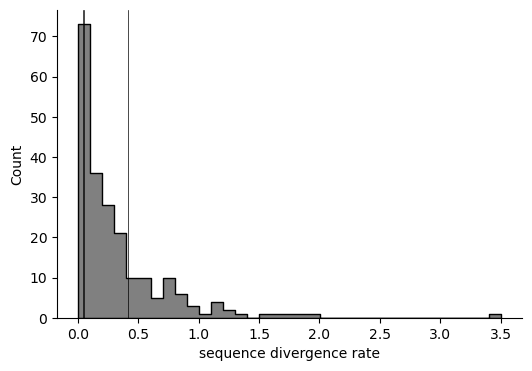

In [128]:
plt.subplots(figsize=(6,4))


genes_of_interest = ["RPS25A", "MSN2", "ARE1"]
pl = sns.histplot(kuzmin_2020_s10.seq_div_rate, 
                binwidth=0.1, 
                color="gray",
                element='step', 
                edgecolor="black", 
                alpha=1)
[plt.axvline(i, color="black", linewidth=0.5) for i in kuzmin_2020_s10.loc[kuzmin_2020_s10.Gene1.isin(genes_of_interest)].seq_div_rate]
pl.set(xlabel='sequence divergence rate')
sns.despine()


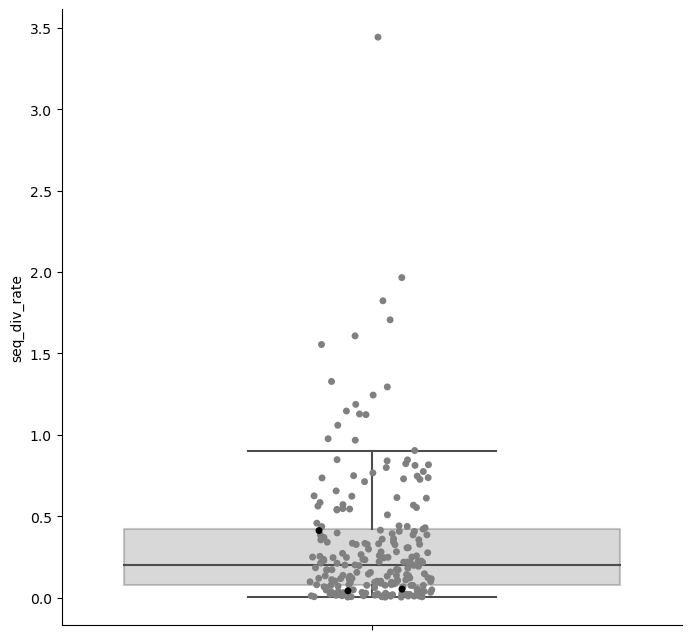

In [115]:
genes_of_interest = ["RPS25A", "MSN2", "ARE1"]
sns.stripplot(y=kuzmin_2020_s10.loc[~kuzmin_2020_s10.Gene1.isin(genes_of_interest)].seq_div_rate,  color="gray")
sns.stripplot(y=kuzmin_2020_s10.loc[kuzmin_2020_s10.Gene1.isin(genes_of_interest)].seq_div_rate, color="black")
sns.boxplot(y=kuzmin_2020_s10.loc[~kuzmin_2020_s10.Gene1.isin(genes_of_interest)].seq_div_rate, 
            showfliers=False,
            color="gray",
            boxprops=dict(alpha=.3))
#[axs[1].axvline(i) for i in kuzmin_2020_s10.loc[kuzmin_2020_s10.Gene1.isin(genes_of_interest)].seq_div_rate]

sns.despine()


In [85]:
genes_of_interest = ["RPS25A_RPS25B", "MSN2_MSN4", "ARE1_ARE2"]
for i in kuzmin_2020_s12.loc[kuzmin_2020_s12.Gene1_Gene2.isin(genes_of_interest)].cor12:
    print(i, np.nanquantile(kuzmin_2020_s12.cor12, i))


0.917641462 0.7721501668075634
0.876762009 0.7413029791544749
0.749090142 0.6835901385542328


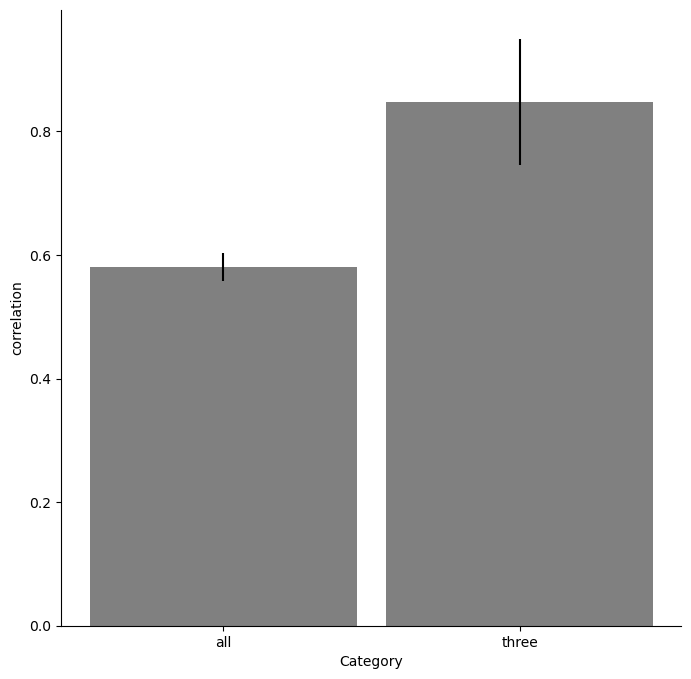

In [100]:
genes_of_interest = ["RPS25A_RPS25B", "MSN2_MSN4", "ARE1_ARE2"]

width = 0.2

d1_mean = np.mean(kuzmin_2020_s12.loc[~kuzmin_2020_s12.Gene1_Gene2.isin(genes_of_interest)].cor12)
d2_mean = np.mean(kuzmin_2020_s12.loc[kuzmin_2020_s12.Gene1_Gene2.isin(genes_of_interest)].cor12)

d1_sem = 2*sem(kuzmin_2020_s12.loc[~kuzmin_2020_s12.Gene1_Gene2.isin(genes_of_interest)].cor12)
d2_sem = 2*sem(kuzmin_2020_s12.loc[kuzmin_2020_s12.Gene1_Gene2.isin(genes_of_interest)].cor12)

plt.bar(0-width, d1_mean, width*1.8, yerr=d1_sem, color="gray")
plt.bar(0+width, d2_mean, width*1.8, yerr=d2_sem, color="gray")

plt.xticks([0-width, 0+width], ['all', 'three'])
plt.xlabel("Category")
plt.ylabel("correlation")

sns.despine()

In [113]:
genes_of_interest = ["RPS25A", "MSN2", "ARE1"]

"""width = 0.2

d1_mean = np.mean(kuzmin_2020_s10.loc[~kuzmin_2020_s10.Gene1.isin(genes_of_interest)].seq_div_rate)
d2_mean = np.mean(kuzmin_2020_s10.loc[kuzmin_2020_s10.Gene1.isin(genes_of_interest)].seq_div_rate)

d1_sem = 2*sem(kuzmin_2020_s10.loc[~kuzmin_2020_s10.Gene1.isin(genes_of_interest)].seq_div_rate)
d2_sem = 2*sem(kuzmin_2020_s10.loc[kuzmin_2020_s10.Gene1.isin(genes_of_interest)].seq_div_rate)

plt.bar(0-width, d1_mean, width*1.8, yerr=d1_sem, color="gray")
plt.bar(0+width, d2_mean, width*1.8, yerr=d2_sem, color="gray")

plt.xticks([0-width, 0+width], ['all', 'three'])
plt.xlabel("Category")
plt.ylabel("correlation")

sns.despine()"""

np.nanpercentile(kuzmin_2020_s10.seq_div_rate, 1)

for i in kuzmin_2020_s10.loc[kuzmin_2020_s10.Gene1.isin(genes_of_interest)].seq_div_rate:
    print((kuzmin_2020_s10.seq_div_rate < i).mean())

0.16666666666666666
0.1875
0.6666666666666666


In [19]:
genes_of_interest = ["RPS25A", "MSN2", "ARE1"]
kuzmin_2020_s10.loc[(kuzmin_2020_s10.Gene1.isin(genes_of_interest)) | (kuzmin_2020_s10.Gene2.isin(genes_of_interest))]
#kuzmin_2020_s10.loc[(kuzmin_2020_s10.Gene1 == "BUL1") | (kuzmin_2020_s10.Gene2 == "BUL1")]

,DM strainID,SM1 strainID,SM2 strainID,ORF1,ORF2,Gene1,Gene2,Asym,seq_div_rate,Global profile sim
26,tm79,tm447,tm1122,YML111W,YMR275C,BUL2,BUL1,0.0,0.037973,0.045
44,tm1533,tm721,tm373,YMR153W,YDL088C,NUP53,ASM4,0.0,0.541760,0.260
91,tm1569,tm1876,tm1827,YGR027C,YLR333C,RPS25A,RPS25B,1.0,0.041332,0.053
109,tm1602,tm1879,tm1833,YOR076C,YKR084C,SKI7,HBS1,0.0,1.823700,0.044
120,tm1606,tm1895,tm1840,YMR037C,YKL062W,MSN2,MSN4,0.0,0.411280,0.038


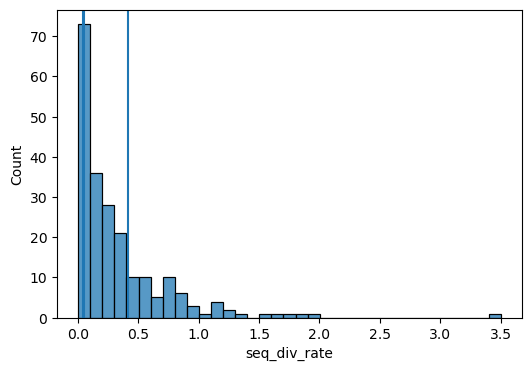

In [37]:
fig, axs = plt.subplots(figsize=(6,4))
genes_of_interest = ["RPS25A", "MSN2", "ARE1"]
sns.histplot(kuzmin_2020_s10.seq_div_rate, binwidth=0.1)
[plt.axvline(i) for i in kuzmin_2020_s10.loc[kuzmin_2020_s10.Gene1.isin(genes_of_interest)].seq_div_rate]
#print(np.nanquantile(kuzmin_2020_s10.seq_div_rate, 0.10))